In [1]:
# All installs here

# Download medium model
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# All imports and installs should be here
import os
import sys
import random

import pandas as pd
import numpy as np
from nltk import wordpunct_tokenize
import operator
import re, string
import math
import spacy
import copy

from nltk import Tree
# Space module import
import en_core_web_md
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from networkx import __version__ as nxv
import networkx.algorithms as networkx_algorithms

# linear_sum_assignment Hungarian algorithm
from scipy.optimize import linear_sum_assignment

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Nice progress bars
from tqdm.notebook import tqdm
# Used in plotting graphs
import matplotlib.pyplot as plt

In [8]:
# All constants

COLAB_ENV = "colab"
LOCAL_ENV = "local"

SENTENCE_START_TOKEN = "sentence_start"
SENTENCE_END_TOKEN = "sentence_end"
UNKNOWN_TOKEN = "unknown_token"


In [9]:
def get_spacy_module():
  return en_core_web_md.load()

In [10]:
# To be able run this notebook from Google Colab and localy

def get_running_env():
  current_path = os.getcwd()
  if current_path == "/content":
    return COLAB_ENV
  return LOCAL_ENV

RUNNING_ENV = get_running_env()

In [11]:
# Supress output of the cell
%%capture
def download_corpus():
    """
      Downloading corpus files for colab research.
    """
    if RUNNING_ENV == LOCAL_ENV:
      return
    files = [
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_train.txt',
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_test.txt',
    ]
    for f in files:
       !curl --remote-name \
          -H 'Accept: application/vnd.github.v3.raw' \
          --location https://api.github.com/repos/{f}

download_corpus()

In [12]:
def get_data_location():
  return "" if RUNNING_ENV == COLAB_ENV else "./dataset/msr-paraphrase-corpus/"

def add_start_end_sentence_tokens(s):
  return "%s %s %s" % (SENTENCE_START_TOKEN, s, SENTENCE_END_TOKEN)

def load_data(_preprocess_sentence=None, _train=False, _test=False):
    "Load the MSRP dataset."
    loc = get_data_location()
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    if _preprocess_sentence is None:
      _preprocess_sentence = lambda x: x

    sent1_train, sent2_train, sent1_test, sent2_test = [], [], [], []
    label_train, label_dev, label_test = [], [], []

    if _train:
        with open(trainloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_train.append(_preprocess_sentence(text[3]))
                sent2_train.append(_preprocess_sentence(text[4]))
                label_train.append(int(text[0]))

    if _test:
        with open(testloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_test.append(_preprocess_sentence(text[3]))
                sent2_test.append(_preprocess_sentence(text[4]))
                label_test.append(int(text[0]))

    if _train and _test:
        return [sent1_train, sent2_train], [sent1_test, sent2_test], [label_train, label_test]
    elif _train:
        return [sent1_train, sent2_train], label_train
    elif _test:
        return [sent1_test, sent2_test], label_test

In [13]:
data = load_data(_preprocess_sentence=None, _train=True, _test=False)

In [14]:
def get_sample_data(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return all_data[0][0][index], all_data[0][1][index], all_data[1][index]

def get_sample(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return {'s1': all_data[0][0][index], 's2': all_data[0][1][index], 'label': all_data[1][index]}



In [15]:
sample = get_sample_data()
sample

('Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.',
 'Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.',
 1)

In [16]:
nlp = get_spacy_module()

In [17]:
def get_dependancy_graph(s, display=False):
  doc = nlp(s)
  if display:
    spacy.displacy.render(doc, style="dep", jupyter=True)
  edges = []
  nodes = [{
      "node": "ROOT",
      "token": None,
      "is_fake": True,
  }]
  for token in doc:
    nodes.append({
        "node": token.text,
        "token": token,
        "is_fake": False,
    })
    if token.dep_ == "ROOT":
      edges.append({
        "start": "ROOT",
        "end": token.text,
        "start_node_id": 0,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
    else:
      edges.append({
        "start": token.head.text,
        "end": token.text,
        "start_node_id":  token.head.i + 1,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
  return {"nodes": nodes, "edges": edges}

graph1 = get_dependancy_graph(sample[0], False)
graph2 = get_dependancy_graph(sample[1], False)
print(graph1)
print(graph2)

{'nodes': [{'node': 'ROOT', 'token': None, 'is_fake': True}, {'node': 'Amrozi', 'token': Amrozi, 'is_fake': False}, {'node': 'accused', 'token': accused, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'brother', 'token': brother, 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'whom', 'token': whom, 'is_fake': False}, {'node': 'he', 'token': he, 'is_fake': False}, {'node': 'called', 'token': called, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': 'the', 'token': the, 'is_fake': False}, {'node': 'witness', 'token': witness, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'of', 'token': of, 'is_fake': False}, {'node': 'deliberately', 'token': deliberately, 'is_fake': False}, {'node': 'distorting', 'token': distorting, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'evidence', 'token': evidence, 'is_fake': False

Here I try to explore diferent Graph similarity algorithms:

First approach
1.   Map nodes using Hungarian algorithm
2.   Count Graph Edit Distance GED also using Hungarian algorithm



In [25]:
# Edge graph data model, credits https://github.com/Jacobe2169/ged4py

class EdgeGraph():
    def __init__(self, init_node, nodes):
        self.init_node=init_node
        self.nodes_ = nodes

    def nodes(self):
        return self.nodes_

    def size(self):
        return len(self.nodes)
    def __len__(self):
        return len(self.nodes_)

class AbstractGraphEditDistance(object):
    def __init__(self, g1, g2):
        self.g1 = g1
        self.g2 = g2

    def normalized_distance(self):
        """
        Returns the graph edit distance between graph g1 & g2
        The distance is normalized on the size of the two graphs.
        This is done to avoid favorisation towards smaller graphs
        """
        avg_graphlen = len(self.g1) + len(self.g2)
        return self.distance() / avg_graphlen

    def distance(self):
        return sum(self.edit_costs())

    def edit_costs(self):
        cost_matrix = self.create_cost_matrix()
        row_ind,col_ind = linear_sum_assignment(cost_matrix)
        return [cost_matrix[row_ind[i]][col_ind[i]] for i in range(len(row_ind))]

    def create_cost_matrix(self):
        """
        Creates a |N+M| X |N+M| cost matrix between all nodes in
        graphs g1 and g2
        Each cost represents the cost of substituting,
        deleting or inserting a node
        The cost matrix consists of four regions:
        substitute 	| insert costs
        -------------------------------
        delete 		| delete -> delete
        The delete -> delete region is filled with zeros
        """
        n = len(self.g1)
        m = len(self.g2)
        cost_matrix = np.zeros((n+m,n+m))
        #cost_matrix = [[0 for i in range(n + m)] for j in range(n + m)]
        nodes1 = list(self.g1.nodes())
        nodes2 = list(self.g2.nodes())

        for i in range(n):
            for j in range(m):
                cost_matrix[i,j] = self.substitute_cost(nodes1[i], nodes2[j])

        for i in range(m):
            for j in range(m):
                cost_matrix[i+n,j] = self.insert_cost(i, j, nodes2)

        for i in range(n):
            for j in range(n):
                cost_matrix[j,i+m] = self.delete_cost(i, j, nodes1)

        self.cost_matrix = cost_matrix
        return cost_matrix

    def insert_cost(self, i, j):
        raise NotImplementedError

    def delete_cost(self, i, j):
        raise NotImplementedError

    def substitute_cost(self, nodes1, nodes2):
        raise NotImplementedError

    def print_matrix(self):
        print("cost matrix:")
        for column in self.create_cost_matrix():
            for row in column:
                if row == sys.maxsize:
                    print ("inf\t")
                else:
                    print ("%.2f\t" % float(row))
            print("")

class EdgeEditDistance(AbstractGraphEditDistance):
    """
    Calculates the graph edit distance between two edges.
    A node in this context is interpreted as a graph,
    and edges are interpreted as nodes.
    """

    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        return sys.maxsize

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def substitute_cost(self, edge1, edge2):
        if edge1 == edge2:
            return 0.
        return 1

class GraphEditDistance(AbstractGraphEditDistance):
    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def substitute_cost(self, node1, node2):
        return self.relabel_cost(node1, node2) + self.edge_diff(node1, node2)

    def relabel_cost(self, node1, node2):
        if node1 == node2:
            return 0.
        else:
            return 1.

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        else:
            return sys.maxsize

    def pos_insdel_weight(self, node):
        return 1

    def edge_diff(self, node1, node2):
        edges1 = list(self.g1.edges(node1))
        edges2 = list(self.g2.edges(node2))
        if len(edges1) == 0 or len(edges2) == 0:
            return max(len(edges1), len(edges2))

        edit_edit_dist = EdgeEditDistance(EdgeGraph(node1,edges1), EdgeGraph(node2,edges2))
        return edit_edit_dist.normalized_distance()

def compare_graphs(g1, g2, print_details=False, use_normalized=True):
    ged = GraphEditDistance(g1, g2)

    if print_details:
        ged.print_matrix()

    return ged.normalized_distance() if use_normalized else ged.distance()


In [26]:
class HungarianGraphNodesMatcher:

  def __init__(self, _g1, _g2, threshold=0.5):
    self.g1 = _g1
    self.g2 = _g2
    self.node_threshold = threshold
    self.create_cost_matrix()
    self.match_nodes()


  def create_cost_matrix(self):
    self.matrix = np.zeros((len(self.g1["nodes"]), len(self.g2["nodes"])))
    for i1, n1 in enumerate(self.g1["nodes"]):
       for i2, n2 in enumerate(self.g2["nodes"]):
         if (not n1["is_fake"] and not n2["is_fake"] and
            n1["token"].has_vector and n2["token"].has_vector):
           self.matrix[i1][i2] = n1["token"].similarity(n2["token"])
         elif n1["is_fake"] == n2["is_fake"]:
           self.matrix[i1][i2] = n1["node"] == n2["node"]
         else:
           self.matrix[i1][i2] = 0

    # Now we need to fleep scores, because Hungarian is trying to minimize
    self.cost = np.subtract(np.full(self.matrix.shape, 1), self.matrix)

  def get_pandas_matrix(self):
    df = pd.DataFrame(
        data=self.matrix,
        index=np.array([n["node"] for n in self.g1["nodes"]]),
        columns=np.array([n["node"] for n in self.g2["nodes"]])
      )

    return df

  def match_nodes(self):
    row_ind, col_ind = linear_sum_assignment(self.cost)

    self.graph1_to_graph2 = {
        item[0]: item[1]
        for item in zip(row_ind, col_ind)
        if self.matrix[item[0]][item[1]] > self.node_threshold
    }
    self.row_ind = row_ind
    self.col_ind = col_ind

  def create_node_aliases(self):
    for id1, n1 in enumerate(self.g1["nodes"]):
      n1["alias"] = "G1_" + str(id1) + n1["node"]
    for id2, n2 in enumerate(self.g2["nodes"]):
      n2["alias"] = "G2_" + str(id2) + n2["node"]
    for id1, id2 in self.graph1_to_graph2.items():
      n1 = self.g1["nodes"][id1]
      n2 = self.g2["nodes"][id2]
      n1["alias"] = "G1_" + str(id1) + "_" + n1["node"] + "_G2_" + str(id2) + "_" + n2["node"]
      n2["alias"] = n1["alias"]

  def build_graph(self, g):
    nx_g = nx.Graph()
    for edge in g["edges"]:
      start_node = g["nodes"][edge["start_node_id"]]
      end_node = g["nodes"][edge["end_node_id"]]
      nx_g.add_edge(start_node["alias"], end_node["alias"])
    return nx_g

  def get_converted_graphs(self):
    self.create_node_aliases()
    g1 = self.build_graph(self.g1)
    g2 = self.build_graph(self.g2)
    return g1, g2

  def print_matched_nodes(self):
    print ("Graph 1  =>   Graph 2")
    for id1, id2 in self.graph1_to_graph2.items():
      print(f"{self.g1['nodes'][id1]['node']}    =>   {self.g2['nodes'][id2]['node']}")

In [27]:
class GraphBuilder:

  def __init__(self):
    pass

  @classmethod
  def build_nx_graph_from_dt(cls, g):
    nx_g = nx.Graph()
    for index, node in enumerate(g["nodes"]):
      nx_g.add_node(index, node=node['node'], token=node['token'], is_fake=node['is_fake'])
    for edge in g["edges"]:
      nx_g.add_edge(edge["start_node_id"], edge["end_node_id"])
    return nx_g


  @classmethod
  def build_nx_graph_from_sentance(cls, s):
    graph = get_dependancy_graph(s, False)
    return cls.build_nx_graph_from_dt(graph)

  @classmethod
  def get_root_node(cls, g):
    main_root_node = [n for n, _ in g.adj[0].items()][0]
    return g.nodes[main_root_node]


In [28]:
node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)

In [29]:
node_matcher.print_matched_nodes()
len(node_matcher.graph1_to_graph2)

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .


16

In [30]:
df = node_matcher.get_pandas_matrix()

df

,ROOT,Referring,to,him,as,only,"""",the,witness,"""",...,Amrozi,accused,his,brother,of,deliberately,distorting,his,evidence,.
ROOT,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amrozi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accused,0.0,0.408382,0.079274,0.218127,0.125133,0.146565,0.158840,0.194780,0.416913,0.158840,...,0.0,1.000000,0.249443,0.339938,0.121041,0.447939,0.178354,0.249443,0.395521,0.099795
his,0.0,0.244812,0.225071,0.551215,0.211184,0.164990,0.071575,0.427005,0.300762,0.071575,...,0.0,0.249443,1.000000,0.432586,0.225210,0.318480,0.126429,1.000000,0.224841,0.226562
brother,0.0,0.297814,0.206064,0.464206,0.190185,0.258868,0.038354,0.235376,0.336928,0.038354,...,0.0,0.339938,0.432586,1.000000,0.057009,0.322739,0.171881,0.432586,0.269477,0.186180
",",0.0,0.501365,0.173606,0.035243,0.373963,0.282212,0.074706,0.401213,0.248256,0.074706,...,0.0,0.265543,0.211008,0.386211,0.313110,0.358542,0.382509,0.211008,0.341190,0.425803
whom,0.0,0.190085,0.162901,0.399088,0.242647,0.245126,0.033570,0.132152,0.294359,0.033570,...,0.0,0.319523,0.368224,0.515097,0.067485,0.259653,-0.028921,0.368224,0.180004,0.028481
he,0.0,0.043702,0.191836,0.635670,0.106898,0.287240,0.105001,0.174022,0.280449,0.105001,...,0.0,0.141543,0.538965,0.394993,-0.094129,0.397204,0.072770,0.538965,0.232456,0.022759
called,0.0,0.673888,0.027694,-0.031650,0.208294,0.164074,0.396181,0.387449,0.266713,0.396181,...,0.0,0.411511,0.101914,0.247313,0.248985,0.321604,0.307080,0.101914,0.264672,0.254899
"""",0.0,0.348231,-0.056760,0.055955,0.164641,-0.021512,1.000000,0.115682,0.152182,1.000000,...,0.0,0.158840,0.071575,0.038354,0.045621,0.220692,0.222701,0.071575,0.112732,0.033789


In [31]:
node_matcher.print_matched_nodes()
g1, g2 = node_matcher.get_converted_graphs()
score = compare_graphs(g1, g2)
print(f"Similarity score {score}")

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .
Similarity score 0.21626544187519794


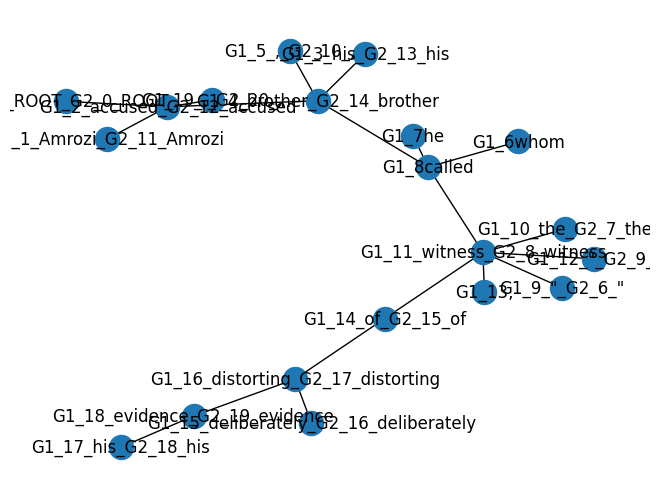

In [32]:
nx.draw(g1, with_labels=True)

In [33]:
def calculate_scores(limit=10):
  result = []
  for i in range(limit):
    s1 = data[0][0][i]
    s2 = data[0][1][i]
    label = data[1][i]
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.8)
    g1, g2 = node_matcher.get_converted_graphs()
    score = compare_graphs(g1, g2)
    result.append((s1, s2, label, score))
  return result

result = calculate_scores()

In [34]:
for d in result:
  print (f"Label {d[2]}  |   Score {d[3]}")

Label 1  |   Score 0.21626544187519794
Label 0  |   Score 0.4032207629768605
Label 1  |   Score 0.2797222222222222
Label 0  |   Score 0.39362745098039215
Label 1  |   Score 0.3335606473904346
Label 1  |   Score 0.26420454545454547
Label 0  |   Score 0.4971768971768971
Label 1  |   Score 0.19363553113553114
Label 0  |   Score 0.4491943241943242
Label 1  |   Score 0.30357142857142855


In [35]:
prepared_data = {}

In [36]:
class DataGenerator:
  @classmethod
  def get_train_data(cls):
    [sent1_train, sent2_train], label_train = load_data(_preprocess_sentence=None, _train=True, _test=False)
    return [
      {"s1": item[0], "s2": item[1], "label": item[2]}
      for item in zip(sent1_train, sent2_train, label_train)
    ]

  @classmethod
  def get_test_data(cls):
    [sent1_test, sent2_test], label_test = load_data(_preprocess_sentence=None, _train=False, _test=True)

    return [
      {"s1": item[0], "s2": item[1], "label": item[2]}
      for item in zip(sent1_test, sent2_test, label_test)
    ]

In [37]:
def prepare_data(feature_generator, force=False, limit=100000):
  feature_name = feature_generator.NAME
  global prepared_data
  if feature_name not in prepared_data or force:
    train_data = DataGenerator.get_train_data()
    test_data = DataGenerator.get_test_data()
    train_X = [
      feature_generator.get_features(item['s1'], item['s2'])
      for item in tqdm(train_data)
    ]
    train_Y = [item['label'] for item in train_data]

    test_X = [
      feature_generator.get_features(item['s1'], item['s2'])
      for item in tqdm(test_data)
    ]
    test_Y = [item['label'] for item in test_data]

    features = {}
    features['train_X'] = train_X
    features['train_Y'] = train_Y
    features['test_X'] = test_X
    features['test_Y'] = test_Y
    prepared_data[feature_name] = features

def verbose_data(feature_generator, limit=10):
    train_data = DataGenerator.get_train_data()
    for item in train_data[:10]:
      features = feature_generator.get_features(item['s1'], item['s2'])
      print(item['s1'])
      print(item['s2'])
      print(f"Label {item['label']}")
      print(features)
      print("*"* 8)

def get_metrics(feature_generator, classificator, force=False, limit=None, features_bitmap=None):
  prepare_data(feature_generator, force, limit)
  global prepared_data
  feature_name = feature_generator.NAME

  train_X = np.array(prepared_data[feature_name]['train_X'])
  test_X = np.array(prepared_data[feature_name]['test_X'])
  if features_bitmap is not None:
    train_X = train_X[:, features_bitmap]
    test_X = test_X[:, features_bitmap]

  classificator.fit(
    train_X,
    prepared_data[feature_name]['train_Y']
  )

  test_Y_predicted = classificator.predict(test_X)

  precision = precision_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  recall = recall_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  f1 = f1_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  accuracy = accuracy_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )

  return {
    "precision" : round(precision * 100, 2),
    "recall" : round(recall * 100, 2),
    "f1" : round(f1 * 100, 2),
    "accuracy" : round(accuracy * 100, 2),
  }

class BaselineFeatureGenerator:
  NAME = 'Baseline'

  def get_features(self, s1, s2):
    return np.array([1])

In [38]:
classificator = LogisticRegression()
baseline_feature_generator = BaselineFeatureGenerator()
print("Baseline")
get_metrics(baseline_feature_generator, classificator, True, 100)

Baseline


  0%|          | 0/4076 [00:00<?, ?it/s]

  0%|          | 0/1725 [00:00<?, ?it/s]

{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}

In [39]:
class HungarianGraphFeatureGenerator:
  NAME = 'HungarianGraph'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    score_normalized = compare_graphs(g1, g2, False, True)
    score_raw = compare_graphs(g1, g2, False, False)
    return np.array([score_normalized, score_raw])

hungarian_feature_generator = HungarianGraphFeatureGenerator()

# It gives {'precision': 73.99, 'recall': 89.54, 'f1': 81.03, 'accuracy': 72.12}
# on LinearSVC()

In [40]:
class HungarianNodeFeatureGenerator:
  NAME = 'HungarianNode'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    n1, n2 = len(g1), len(g2)
    num_matched_nodes = len(node_matcher.graph1_to_graph2)
    percent_matched = num_matched_nodes * 2. / (n1 + n2)
    features = np.array([n1, n2, percent_matched])
    return features

hungarian_node_feature_generator = HungarianNodeFeatureGenerator()
# It gives {'precision': 74.5, 'recall': 90.67, 'f1': 81.79, 'accuracy': 73.16}
# on SGDClassifier(),

In [41]:
verbose_data(hungarian_node_feature_generator)


Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[20.        21.         0.7804878]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[18.         23.          0.58536585]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[22.         23.          0.75555556]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.
Label 0
[30.         21.          0.666666

In [42]:
def base_classification_test(feature_generator, verbose=True, features_bitmap=None,):
  classificators = [
    {
      "name": "SVC",
      "classificator": SVC(),
    },
    {
      "name": "SVC(kernel = 'rbf', random_state = 0)",
      "classificator": SVC(kernel = 'rbf', random_state = 0),
    },
    {
      "name": "SVC(probability=True)",
      "classificator": SVC(probability=True),
    },
    {
      "name": "NuSVC",
      "classificator": NuSVC(),
    },
    {
      "name": "LinearSVC",
      "classificator": LinearSVC(),
    },
    {
      "name": "DecisionTreeClassifier",
      "classificator": DecisionTreeClassifier(),
    },
    {
      "name": "DecisionTreeClassifier(criterion='entropy',random_state=0)",
      "classificator": DecisionTreeClassifier(criterion="entropy",random_state=0),
    },
    {
      "name": "ExtraTreeClassifier",
      "classificator": ExtraTreeClassifier(),
    },
    {
      "name": "KNeighborsClassifier",
      "classificator": KNeighborsClassifier(),
    },
    {
      "name": " KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)",
      "classificator":  KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2),
    },
    {
      "name": "GaussianNB",
      "classificator": GaussianNB(),
    },
    {
      "name": "BernoulliNB",
      "classificator": BernoulliNB(),
    },
    {
      "name": "Perceptron",
      "classificator": Perceptron(),
    },
    {
      "name": "SGDClassifier",
      "classificator": SGDClassifier(),
    },
    {
      "name": "RandomForestClassifier",
      "classificator": RandomForestClassifier(),
    },
    {
      "name": "RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0)",
      "classificator": RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0),
    },
    {
      "name": "LogisticRegressionCV",
      "classificator": LogisticRegressionCV(),
    },
    {
      "name": "PassiveAggressiveClassifier",
      "classificator": PassiveAggressiveClassifier(),
    },
    {
      "name": "RidgeClassifierCV",
      "classificator": RidgeClassifierCV(),
    },
    {
      "name": "LogisticRegression(max_iter = 500000)",
      "classificator": LogisticRegression(max_iter = 500000),
    },
    {
      "name": "GradientBoostingClassifier",
      "classificator": GradientBoostingClassifier(),
    },
  ]
  res = []
  for item in tqdm(classificators):
    score = get_metrics(feature_generator, item["classificator"], features_bitmap=features_bitmap)
    res.append({"classificator": item["name"], "score": score})

  if verbose:
    for r in res:
      print(r["classificator"])
      print(r["score"])
  return res

In [ ]:
# Uncomment to test
# prepare_data(hungarian_feature_generator, True, 100000)
# base_classification_test(hungarian_feature_generator)

In [ ]:
# Uncomment to test
# prepare_data(hungarian_node_feature_generator, True, 100000)
# base_classification_test(hungarian_node_feature_generator)

In [43]:
def plot_graphs(graphs, word_labels=False):
  for g in graphs:
     fig, ax = plt.subplots(1, 1)
     if word_labels:
       nx.draw(g, with_labels=True, pos=nx.kamada_kawai_layout(g), ax=ax, labels={n: g.nodes[n]['node'] for n in g.nodes})
     else:
       nx.draw(g, with_labels=True, pos=nx.kamada_kawai_layout(g), ax=ax)

In [44]:
class GraphTraversal:
  def __init__(self, graph=None, sentance=None):
    assert graph is not None or sentance is not None
    if graph is not None:
      self.g = graph
    else:
      self.g = GraphBuilder.build_nx_graph_from_sentance(sentance)

  def get_paths_from_root_to_leafs(self, root=0):
     #                 node. parent. path.
    res, stack = [], [(root, None, [])]
    while stack:
        node, parent, path = stack.pop()
        path.append(node)
        neighbours = [n for n, _ in self.g.adj[node].items()]
        if len(neighbours) == 1 and neighbours[0] == parent:
            res.append(path)
        for n in neighbours:
          if n == parent:
            continue
          stack.append((n, node, path[:]))
    return res

  def get_all_paths_with_len(self, root=0, length=0):
    #                  node. parent. path.
    res, stack = [], [(root, None, [])]
    started_new_path = {root}
    while stack:
        node, parent, path = stack.pop()
        path.append(node)
        neighbours = [n for n, _ in self.g.adj[node].items()]
        if len(path) == length + 1:
          res.append(path)
        for n in neighbours:
          if n == parent:
            continue
          if len(path) < length + 1:
            stack.append((n, node, path[:]))
          if n not in started_new_path:
            stack.append((n, node, []))
            started_new_path.add(n)

    return res

  def get_all_subtrees_with_depth(self, root=0, parent=None, length=0):
    """
      Return array of subtrees.
      Each subtree is defined by indexes of their nodes.
    """
    #                  node. parent. distance.
    res, stack = [], [(root, parent, 0)]
    reached_depth = False
    while stack:
        node, _parent, distance = stack.pop()
        res.append(node)
        if distance >= length:
          reached_depth = True
          continue
        neighbours = [n for n, _ in self.g.adj[node].items()]
        for n in neighbours:
          if n == _parent:
            continue
          stack.append((n, node, distance + 1))

    all_subtrees = []
    if reached_depth:
      all_subtrees.append(res)
    for n, _ in self.g.adj[root].items():
      if n == parent:
        continue
      all_subtrees += self.get_all_subtrees_with_depth(n, root, length)

    return all_subtrees

In [45]:
class GraphFeatures:
  def __init__(self, graph=None, sentance=None):
    assert graph is not None or sentance is not None
    if graph is not None:
      self.g = graph
    else:
      self.g = GraphBuilder.build_nx_graph_from_sentance(sentance)

  def get_path_features(self, length=0):
    traversal = GraphTraversal(graph=self.g)
    pathes = traversal.get_all_paths_with_len(length=length)

    pathes_with_nodes = [
      [self.g.nodes[node] for node in path ]
      for path in pathes
    ]

    filtered_pathes_with_nodes = [
      path
      for path in pathes_with_nodes
      if all(
          node["token"] is not None and node["token"].has_vector
          for node in path
      )
    ]

    aggregated_vectors = [
       sum([node["token"].vector for node in path])
       for path in filtered_pathes_with_nodes
    ]

    return aggregated_vectors

  def get_subtree_features(self, length=0, remove_tree_without_vector=True, remove_stop_words=False):
    """
    Return list of vectors, where each vector represent one subtree.
    Subtree is created by aggregating vectors in this subtree.

    Keyword arguments:
    length -- the real part (default 0.0)
    remove_tree_without_vector -- remove whole tree if at least one vector inside it
      is empty (non common word)
    remove_stop_words - remove word from tree if it is stop word
    """
    traversal = GraphTraversal(graph=self.g)
    subtrees = traversal.get_all_subtrees_with_depth(length=length)

    subtrees_with_nodes = [
      [self.g.nodes[node] for node in subtree ]
      for subtree in subtrees
    ]

    if remove_tree_without_vector:
      subtrees_with_nodes = [
        subtree
        for subtree in subtrees_with_nodes
        if all(
            node["token"] is not None and node["token"].has_vector
            for node in subtree
        )
      ]

    aggregated_vectors = [
       sum([
          node["token"].vector
          for node in subtree
          # If remove_tree_without_vector == false
          if node["token"] is not None and node["token"].has_vector
          and (not remove_stop_words or not node["token"].is_stop)
        ])
       for subtree in subtrees_with_nodes
    ]

    # Filter empty vectors
    aggregated_vectors = [
      v
      for v in aggregated_vectors
      if not np.isscalar(v)
    ]

    return aggregated_vectors

In [46]:
class Vector:
  @classmethod
  def get_norm(cls, v):
    total = (v ** 2).sum()
    return np.sqrt(total) if total != 0 else 0

  @classmethod
  def similarity(cls, v1, v2):
    v1_norm = cls.get_norm(v1)
    v2_norm = cls.get_norm(v2)
    if v1_norm == 0 or v1_norm == 0:
      return 0.0
    return (np.dot(v1, v2) / (v1_norm * v2_norm))

class MatchFeatureVectors:
  @classmethod
  def match_feature_vectors(cls, features1, features2, similarity=0.8):
    """
      This function tries to do the following:
      1) For each vector in features1 try to find whether vector with good similarity exist in features2.
      Return ammount of matched vectors.
    """
    count = 0

    features1_norm = []
    for v1 in features1:
      for v2 in features2:
        score = Vector.similarity(v1, v2)
        if score > similarity:
          count += 1
          break
    return count

In [47]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])
g_f1 = GraphFeatures(g1)
g_f2 = GraphFeatures(g2)
f1 = g_f1.get_subtree_features(length=1)
f2 = g_f2.get_subtree_features(length=1)
score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=0.8)
print (score)

5


In [48]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])
g_f1 = GraphFeatures(g1)
g_f2 = GraphFeatures(g2)
f1 = g_f1.get_path_features(length=3)
f2 = g_f2.get_path_features(length=3)
score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=0.8)
print (score)

5


In [49]:
class PathFeatureGenerator:
  NAME = 'PathSimilarity'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_path_features(length=length)
    f2 = g_f2.get_path_features(length=length)

    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

path_feature_generator = PathFeatureGenerator()
# SGDClassifier {'precision': 74.34, 'recall': 90.41, 'f1': 81.59, 'accuracy': 72.87} [True, False, True, False, True]

In [50]:
verbose_data(path_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.81081081 0.74285714 0.42857143 0.47619048 1.        ]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.61538462 0.54054054 0.61538462 0.82352941 0.75      ]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.79069767 0.73170732 0.82758621 0.88888889 0.85714286]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closin


It seems that PathFeatureGenerator with more length are giving more stable (core) feature.



In [ ]:
# Uncomment to test
# prepare_data(path_feature_generator, True)
# base_classification_test(path_feature_generator)

In [51]:
def get_all_bitmasks(length):
  res = []
  for i in range(1, 2 ** length):
     bitmask = np.zeros(length)
     n = int(i)
     pos = 0
     while n > 0:
       bitmask[pos] = n % 2
       pos += 1
       n = n // 2
     bitmask = [b == 1 for b in bitmask]
     res.append(bitmask)
  return res


def feature_selection(feature_generator, top_results=5, verbose=False, bitmask_amount=None):
  global prepared_data
  feature_name = feature_generator.NAME
  assert feature_name in prepared_data
  length = len(prepared_data[feature_generator.NAME]["test_X"][0])
  bitmasks = get_all_bitmasks(length)
  results = []
  if bitmask_amount is not None:
    random.shuffle(bitmasks)
    bitmasks = random.sample(bitmasks, bitmask_amount)
  for bitmask in tqdm(bitmasks):
    if verbose:
      print(f"mask {bitmask}")
    scores = base_classification_test(feature_generator, features_bitmap=bitmask, verbose=False)
    for score in scores:
      if verbose:
        print(f"classificator {score['classificator']}")
        print(f"score {score['score']}")

      results.append({
        "mask": bitmask,
        "score": score["score"],
        "classificator": score["classificator"]
      })

  results = sorted(results, key=lambda k: k["score"]["accuracy"], reverse=True)
  print("Top Accuracy")
  for r in results[:top_results]:
    print(f"{r['classificator']} {r['score']} {r['mask']}")

  results = sorted(results, key=lambda k: k["score"]["f1"], reverse=True)
  print("Top F1")
  for r in results[:top_results]:
    print(f"{r['classificator']} {r['score']} {r['mask']}")

# Uncomment to run feature selection
# feature_selection(path_feature_generator)

In [52]:
doc = nlp("Give it back! He pleaded.")
token = doc[0]
vector = token.vector
total = (vector ** 2).sum()
norm = np.sqrt(total) if total != 0 else 0
print(norm)
print(token.vector_norm)

45.612625
45.612625


In [53]:
sample = get_sample(0)
g1 = GraphBuilder.build_nx_graph_from_sentance(sample['s1'])
g2 = GraphBuilder.build_nx_graph_from_sentance(sample['s2'])


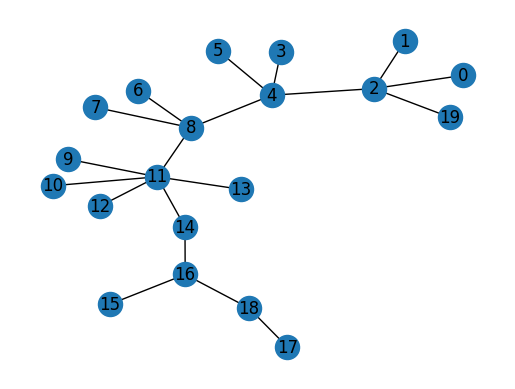

In [54]:
plot_graphs([g1])

In [56]:
class SimpleGraphVector:
  @classmethod
  def get_graph_vector(cls, g):
    """
    g: networkx graph
    Return vector
    """
    vectors = []
    for node_index in g.nodes:
      node = g.nodes[node_index]
      if node['token'] is not None and node['token'].has_vector:
        attention = g.degree[node_index]
        vectors.append(attention * np.array(node['token'].vector))
    return sum(vectors)

In [57]:
class SimpleGraphVectorFeatureGenerator:
  """
  Compute only one feature - one vector of the whole tree
  """
  NAME = 'SimpleGraphVectorFeatureGenerator'

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    v1 = SimpleGraphVector.get_graph_vector(g1)
    v2 = SimpleGraphVector.get_graph_vector(g2)

    features = np.array([
      Vector.similarity(v1, v2)
    ])

    return features

simple_graph_vector_feature_generator = SimpleGraphVectorFeatureGenerator()
# GaussianNB {'precision': 71.35, 'recall': 92.5, 'f1': 80.56, 'accuracy': 70.32}

In [58]:
# Uncomment to test
# prepare_data(simple_graph_vector_feature_generator, True, 10000)
# base_classification_test(simple_graph_vector_feature_generator)

In [59]:
verbose_data(simple_graph_vector_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.95041287]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.90469277]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.94978964]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.
Label 0
[0.904455]
********
The stock rose $2.11, or about 11 percent, to close Friday at $21.51 on the New York S

In [60]:
class SubtreeFeatureGenerator:
  NAME = 'SubtreeFeature'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_subtree_features(length=length)
    f2 = g_f2.get_subtree_features(length=length)

    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

subtree_feature_generator = SubtreeFeatureGenerator()
# LinearSVC {'precision': 74.85, 'recall': 89.8, 'f1': 81.65, 'accuracy': 73.16}
# SGDClassifier {'precision': 74.84, 'recall': 90.5, 'f1': 81.93, 'accuracy': 73.45}
# LogisticRegression(max_iter = 500000) {'precision': 75.02, 'recall': 90.32, 'f1': 81.96, 'accuracy': 73.57} [True, True, True, True, False]

In [ ]:
# Uncomment to test
# prepare_data(subtree_feature_generator, True, 10000)
# scores = base_classification_test(subtree_feature_generator)
# Uncomment to run feature selection
# feature_selection(subtree_feature_generator)

In [61]:
verbose_data(subtree_feature_generator, 10)

Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[0.81081081 0.71428571 0.88888889 1.         0.        ]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[0.61538462 0.63157895 0.75       1.2        0.66666667]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[0.79069767 0.57142857 0.92307692 1.         1.33333333]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closin

In [62]:
class RootNodeFeatureGenerator:
  NAME = 'RootNodeFeature'

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    root_node1 = GraphBuilder.get_root_node(g1)
    root_node2 = GraphBuilder.get_root_node(g2)

    if root_node1['token'].has_vector and root_node2['token'].has_vector:
      score = root_node1['token'].similarity(root_node2['token'])
    else:
      score = 0

    features = np.array([
      score,
    ])

    return features

root_node_feature_generator = RootNodeFeatureGenerator()
# SVC {'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
# By itself is not usefull, but maybe in combination could be used.

In [63]:
# prepare_data(root_node_feature_generator, True, 10000)
# scores = base_classification_test(root_node_feature_generator)


Try to remove stop words (don't use their vectors):
 - Results:
    SubtreeFeature - not very usefull
    

In [65]:
class SubtreeFeatureGeneratorWithoutStopWords:
  NAME = 'SubtreeFeatureWithoutStopWords'

  SIMILARITY = 0.8

  def get_feature_for_length(self, g_f1, g_f2, length):
    f1 = g_f1.get_subtree_features(length=length, remove_stop_words=True)
    f2 = g_f2.get_subtree_features(length=length, remove_stop_words=True)

    score = MatchFeatureVectors.match_feature_vectors(f1, f2, similarity=self.SIMILARITY)

    norm = len(f1) + len(f2)
    return (score * 2.) / norm if norm != 0 else 0

  def get_features(self, s1, s2):
    g1 = GraphBuilder.build_nx_graph_from_sentance(s1)
    g2 = GraphBuilder.build_nx_graph_from_sentance(s2)

    g_f1 = GraphFeatures(g1)
    g_f2 = GraphFeatures(g2)

    features = np.array([
      self.get_feature_for_length(g_f1, g_f2, 0),
      self.get_feature_for_length(g_f1, g_f2, 1),
      self.get_feature_for_length(g_f1, g_f2, 2),
      self.get_feature_for_length(g_f1, g_f2, 3),
      self.get_feature_for_length(g_f1, g_f2, 4),
    ])

    return features

subtree_without_stop_words_feature_generator = SubtreeFeatureGeneratorWithoutStopWords()

In [ ]:
# prepare_data(subtree_without_stop_words_feature_generator, True, 10000)
# scores = base_classification_test(subtree_without_stop_words_feature_generator)
# feature_selection(subtree_without_stop_words_feature_generator, verbose=False)

# Results
# SVC {'precision': 72.9, 'recall': 91.46, 'f1': 81.13, 'accuracy': 71.71}
# feature selection didn't improve results


In [66]:
class AllFeatureGenerator:
  NAME = 'AllFeatures'

  def get_features(self, s1, s2):
    generators = [
        HungarianGraphFeatureGenerator(),
        HungarianNodeFeatureGenerator(),
        PathFeatureGenerator(),
        SubtreeFeatureGenerator(),
    ]
    features = np.array([])
    for generator in generators:
      features = np.append(features, generator.get_features(s1, s2))
    return features

all_feature_generator = AllFeatureGenerator()
# LogisticRegression(max_iter = 500000) {'precision': 76.04, 'recall': 88.84, 'f1': 81.95, 'accuracy': 73.97}
# RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=0) {'precision': 76.32, 'recall': 88.23, 'f1': 81.84, 'accuracy': 73.97}

# RidgeClassifierCV {'precision': 76.28, 'recall': 89.71, 'f1': 82.45, 'accuracy': 74.61} [True, False, True, False, False, True, False, False, True, False, True, True, False, True, False]
# LogisticRegressionCV {'precision': 76.8, 'recall': 88.58, 'f1': 82.27, 'accuracy': 74.61} [True, False, True, True, True, False, False, True, True, True, False, False, True, True, False]
# RidgeClassifierCV {'precision': 76.09, 'recall': 90.15, 'f1': 82.52, 'accuracy': 74.61} [True, True, False, False, False, True, True, False, False, False, True, True, False, False, True]
# LogisticRegression(max_iter = 500000) {'precision': 76.4, 'recall': 89.45, 'f1': 82.41, 'accuracy': 74.61} [True, False, True, True, True, True, False, True, True, True, False, False, False, True, False]


In [ ]:
# prepare_data(all_feature_generator, True, 10000)
# scores = base_classification_test(all_feature_generator)
# all_feature_generator = AllFeatureGenerator()
# feature_selection(all_feature_generator, verbose=True, bitmask_amount=100)

In [67]:
class AllFeatureGeneratorV1:
  NAME = 'AllFeatureV1'

  def get_features(self, s1, s2):
    generators = [
        HungarianGraphFeatureGenerator(),
        HungarianNodeFeatureGenerator(),
        PathFeatureGenerator(),
        SubtreeFeatureGenerator(),
        SubtreeFeatureGeneratorWithoutStopWords(),
    ]
    features = np.array([])
    for generator in generators:
      features = np.append(features, generator.get_features(s1, s2))
    return features

all_feature_generator_v1 = AllFeatureGeneratorV1()

In [ ]:
# prepare_data(all_feature_generator, True, 10000)
# scores = base_classification_test(all_feature_generator)
# all_feature_generator = AllFeatureGenerator()
# feature_selection(all_feature_generator, verbose=False, bitmask_amount=100)

# Top Accuracy
# LinearSVC {'precision': 76.62, 'recall': 89.45, 'f1': 82.54, 'accuracy': 74.84} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# RidgeClassifierCV {'precision': 76.57, 'recall': 89.45, 'f1': 82.51, 'accuracy': 74.78} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# LogisticRegression(max_iter = 500000) {'precision': 76.79, 'recall': 88.84, 'f1': 82.38, 'accuracy': 74.72} [False, True, False, True, True, True, False, False, False, True, False, True, False, False, True]
# LogisticRegression(max_iter = 500000) {'precision': 76.59, 'recall': 89.28, 'f1': 82.45, 'accuracy': 74.72} [False, False, True, True, True, False, False, True, False, False, True, False, True, True, False]
# RidgeClassifierCV {'precision': 76.83, 'recall': 88.75, 'f1': 82.36, 'accuracy': 74.72} [False, False, False, False, True, True, False, True, False, False, False, True, True, True, False]
# Top F1
# LogisticRegression(max_iter = 500000) {'precision': 76.01, 'recall': 90.32, 'f1': 82.55, 'accuracy': 74.61} [True, False, True, False, False, True, True, True, False, True, False, False, False, True, True]
# LinearSVC {'precision': 76.62, 'recall': 89.45, 'f1': 82.54, 'accuracy': 74.84} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# RidgeClassifierCV {'precision': 76.57, 'recall': 89.45, 'f1': 82.51, 'accuracy': 74.78} [True, False, False, False, False, False, False, False, True, True, True, True, True, True, False]
# SGDClassifier {'precision': 75.22, 'recall': 91.28, 'f1': 82.47, 'accuracy': 74.2} [False, True, True, False, True, False, False, False, False, False, True, True, False, True, False]
# Perceptron {'precision': 75.97, 'recall': 90.15, 'f1': 82.46, 'accuracy': 74.49} [True, False, True, False, True, False, False, False, False, False, True, True, True, False, False]

In [68]:
class AnalyzePredictions:
  CORRECT_PREDICTIONS = 'CORRECT_PREDICTIONS'
  WRONG_PREDICTIONS = 'WRONG_PREDICTIONS'

  @classmethod
  def get_predictions(cls, feature_generator, classificator, mode, verbose=True, limit=10):
    feature_name = feature_generator.NAME
    assert feature_name in prepared_data, "No features found"

    test_data = DataGenerator.get_test_data()

    train_X = prepared_data[feature_name]['train_X']
    test_X = prepared_data[feature_name]['test_X']
    train_Y = prepared_data[feature_name]['train_Y']
    test_Y = prepared_data[feature_name]['test_Y']


    classificator.fit(train_X, train_Y)

    test_Y_predicted = classificator.predict(test_X)

    res = []
    for data, features, prediction, label in zip(test_data, test_X, test_Y_predicted, test_Y):
      if (mode == AnalyzePredictions.CORRECT_PREDICTIONS and prediction == label or
         mode == AnalyzePredictions.WRONG_PREDICTIONS and prediction != label):
          res.append({
              "raw": data,
              "features": features,
              "prediction": prediction,
              "label": label
          })
          if verbose:
            print(data)
            print(features)
            print(f"Prediction {prediction}, but label {label}")
          limit -= 1
          if limit == 0:
            break
    return res



In [69]:
model = LinearSVC()
prepare_data(subtree_feature_generator, True, 10000)
not_predicted = AnalyzePredictions.get_predictions(subtree_feature_generator, model, AnalyzePredictions.WRONG_PREDICTIONS,  verbose=False)
ok_predicted = AnalyzePredictions.get_predictions(subtree_feature_generator, model, AnalyzePredictions.CORRECT_PREDICTIONS,  verbose=False, limit=10)
sample_wrong = not_predicted[0]
sample_ok = ok_predicted[0]


  0%|          | 0/4076 [00:00<?, ?it/s]

  0%|          | 0/1725 [00:00<?, ?it/s]

In [71]:
def print_sample(p):
  print (p["raw"]["s1"])
  print (p["raw"]["s2"])
  print (f"Label {p['raw']['label']}")
  print (f"Prediction {p['prediction']}")
  print (p["features"])
print_sample(sample_wrong)
print_sample(sample_ok)



PCCW's chief operating officer, Mike Butcher, and Alex Arena, the chief financial officer, will report directly to Mr So.
Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So.
Label 1
Prediction 0
[0.51162791 0.28571429 0.28571429 0.5        0.        ]
According to the federal Centers for Disease Control and Prevention (news - web sites), there were 19 reported cases of measles in the United States in 2002.
The Centers for Disease Control and Prevention said there were 19 reported cases of measles in the United States in 2002.
Label 1
Prediction 1
[0.79245283 0.8        0.66666667 0.76923077 0.66666667]
